# Search Parameters

In [1]:
seed = 70 # seed for NMF topic model
num_topics = 12
query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("neurotransmitter" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine" OR "GABA"))'
# query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "anxiety" OR "eating disorder"))'
# query = 'title-abs-key("neurotransmitter" AND ("GABA" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine") AND ("mental health" OR "mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "eating disorder" OR "anxiety"))'
# query = 'title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("mental health" OR "mental disorder" OR "mood disorder" OR "depression" OR "major depressive disorder" OR "eating disorder" OR "anxiety") AND ("GABA" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine"))'
# query = 'title-abs-key("deep learning" AND ("autonomous" OR "self-driving" OR "robotic" OR "driverless" AND ("car" OR "cars" OR "driving")))'
# query = 'title-abs-key("autonomous driving" OR "self-driving car" OR "robotic car" OR "driverless car")'
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
vis_seed = 6 # seed for t-SNE visualization
vis_angle = 135 # rotation angle for visualization

# Import Modules

In [2]:
import random
import gensim
import pybliometrics.scopus as scopus
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
import ipywidgets as widgets

from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict

import seaborn as sns
sns.set('paper')

import logging
logging.getLogger().setLevel(logging.INFO)

# some python 3 trickery
import sys
if sys.version_info[0] >= 3:
    unicode = str

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

# Perform Query

In [4]:
eids = scopus.ScopusSearch(query).get_eids()
random.seed(0)
random.shuffle(eids)

bar = widgets.IntProgress(
    min=0, 
    max=len(eids), 
    description='Loading')
display(bar)

print('query: {} ({} results)'.format(query, len(eids)))

papers = []
for eid in eids:
    papers.append(scopus.AbstractRetrieval(eid, view='FULL'))
    bar.value += 1
    bar.description = str(bar.value)

print('scopus returned {} results'.format(len(papers)))

# Filter on article type
# ar = article, cp = conference proceeding, re = review
print(set([p.srctype for p in papers]))

# Filter on citation type
#papers = [p for p in papers if p.citationType in ('ar', 'cp', 're') or p.citationType is None]

# Filter on date
#papers = [p for p in papers if int(p.coverDate[:4]) <= 2018]

print('{} papers remaining'.format(len(papers)))

IntProgress(value=0, description='Loading', max=835)

query: title-abs-key("gut flora" OR "gut microbiota" OR "intestinal bacteria" AND ("neurotransmitter" OR "serotonin" OR "5-HT" OR "dopamine" OR "norepinephrine" OR "GABA")) (835 results)


Scopus404Error: The resource specified cannot be found.

In [5]:
texts = []
for p in papers:
    text = (p.title or '') + ' ' + (p.abstract or '')
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
    texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items

# Analysis

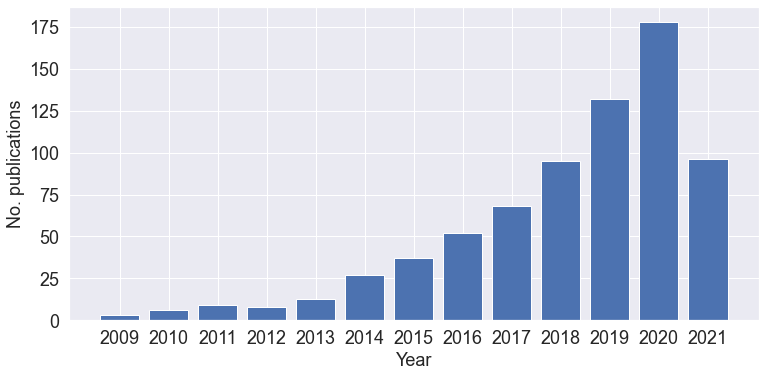

In [6]:
# Publications per year
year_count = defaultdict(int)

for p in papers:
    year_count[int(p.coverDate[:4])] += 1
       
years = range(2009, 2022)

prepare_fig(1.8, 1.8)
plt.ylabel("No. publications",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.bar(
    years,
    [year_count[y] for y in years])
plt.xticks(years);
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('years_ad.pdf')

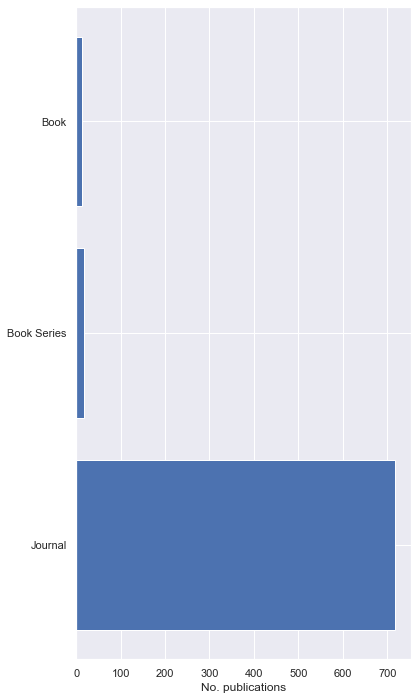

In [7]:
# Publications per aggregation type
def plot_statistic(fun):
    count = defaultdict(int)

    for p in papers:
        for key in fun(p):
            if key:
                count[unicode(key)] += 1

    top_keys = top_k(count, 50)

    prepare_fig(1, 4)
    plt.xlabel("No. publications")
    plt.barh(
        range(len(top_keys)),
        [count[a] for a in top_keys])
    plt.yticks(
        range(len(top_keys)), 
        [key[:50] for key in top_keys])
    plt.show()

plot_statistic(lambda p: [p.aggregationType])

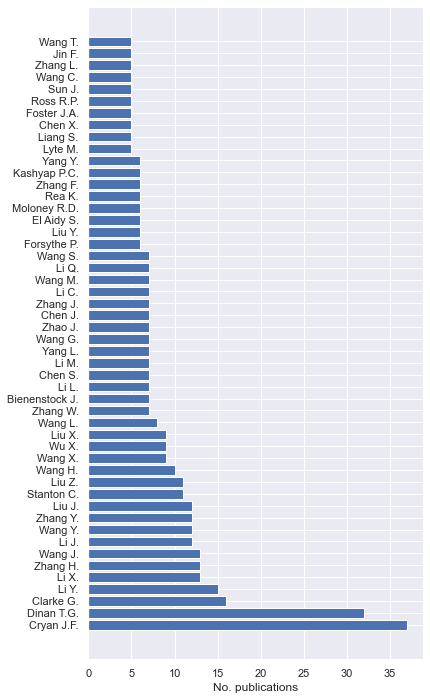

In [8]:
# Publications per author
plot_statistic(lambda p: set(a.indexed_name for a in p.authors or []))

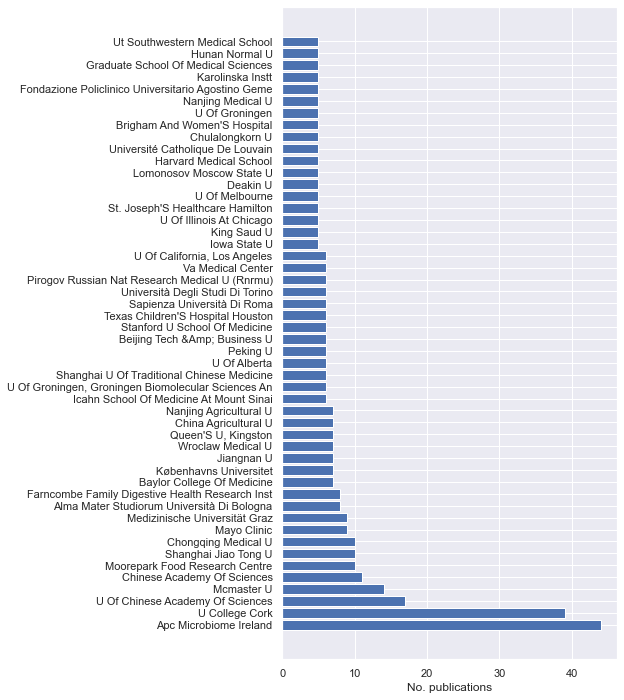

In [9]:
# Publications per institute
def clean_affiliation(name):
    name = unicode(name).title()
    pairs = [
        ['University', 'U'],
        ['Universitat', 'U'],
        ['Laboratories', 'Lab'],
        ['Laboratory', 'Lab'],
        ['National', 'Nat'],
        ['Corporation', 'Corp'],
        ['Technology', 'Tech'],
        ['Institute', 'Inst'],
    ]
    
    for needle, replacement in pairs:
        name = name.replace(needle, replacement)
    return name

plot_statistic(lambda p: set(clean_affiliation(a.name) for a in p.affiliation or []))

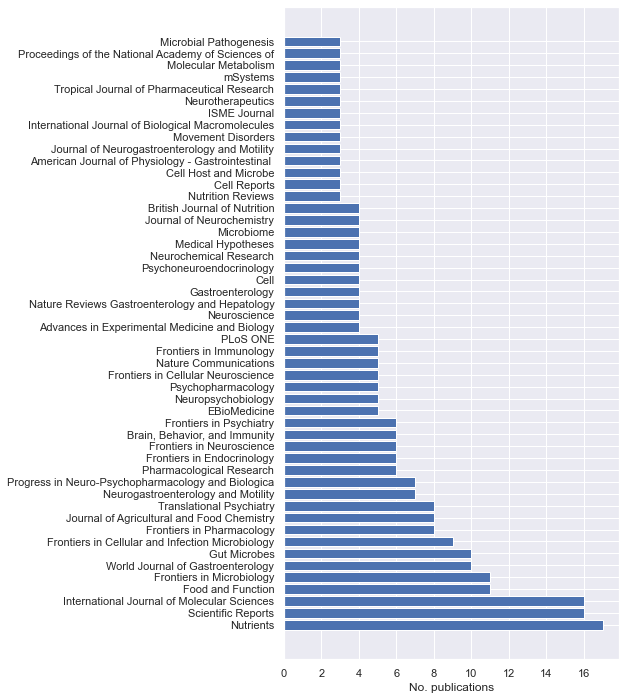

In [10]:
# Publications per publication source, conference/journal (TODO: cleaning!)
plot_statistic(lambda p: [p.publicationName])

# Topic Modeling
## Preprocessing

In [11]:
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        stopwords = [w.strip() for w in f if w.strip()]
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

loaded 152 stopwords
loaded 42 bigrams
loaded 2 stem rules


In [12]:
# Print common words
one_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
        
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'in stopwords.txt?']))

Top words


,word,count,in stopwords.txt?
0,the,10213,Yes
1,and,7971,Yes
2,of,7160,Yes
3,in,5374,Yes
4,gut,3286,
5,to,2910,Yes
6,microbiota,2561,
7,a,2386,
8,with,1621,Yes
9,that,1518,Yes


In [13]:
# Print common bigrams
two_count = defaultdict(int)

for text in texts:
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1
            
print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w], 'Yes' * (w in bigrams)) for w in top_k(two_count, 250)],
    columns=['bigram', 'count', 'in bigrams.txt?']))

Top bigrams


,bigram,count,in bigrams.txt?
0,"(gut, microbiota)",1695,
1,"(gut, brain)",410,
2,"(brain, axis)",372,
3,"(5, ht)",275,
4,"(nervous, system)",221,
5,"(gut, microbiome)",212,
6,"(s, disease)",152,
7,"(microbiota, gut)",145,
8,"(central, nervous)",134,
9,"(p, 0)",132,


In [14]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [15]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [16]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()


# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))
pd.DataFrame(
    [(
        token, 
        stemming[token], 
        unstemming[stemming[token]], 
        word_count[token]
    ) for token in top_k(word_count, k=250)],
    columns=['Original', 'Stem', 'Unstem', 'Count'])

INFO:root:stemming reduced 10447 to 7612 tokens


,Original,Stem,Unstem,Count
0,gut,gut,gut,3286
1,microbiota,microbiota,microbiota,2561
2,brain,brain,brain,1192
3,intestinal,intestin,intestinal,619
4,mice,mice,mice,616
5,axis,axi,axis,564
6,system,system,system,501
7,role,role,role,501
8,effects,effect,effects,492
9,disorders,disord,disorders,473


## Create Dictionary

In [17]:
# Remove papers with less than 25 words after preprocessing
n = len(papers)
indices = [i for i in range(len(papers)) if len(stemmed_texts[i]) > 25]
papers = [papers[i] for i in indices]
final_texts = [stemmed_texts[i] for i in indices]

print('papers: {} (removed {})'.format(len(papers), n - len(papers)))

papers: 739 (removed 8)


In [18]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7611 unique tokens: ['action', 'addition', 'administered', 'amp', 'ampicillin']...) from 739 documents (total 110046 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary(7611 unique tokens: ['action', 'addition', 'administered', 'amp', 'ampicillin']...) from 739 documents (total 110046 corpus positions)", 'datetime': '2021-05-20T11:53:57.144957', 'gensim': '4.0.1', 'python': '3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:59:12) \n[Clang 11.0.1 ]', 'platform': 'Darwin-19.6.0-x86_64-i386-64bit', 'event': 'created'}
INFO:gensim.corpora.dictionary:discarding 5 tokens: [('effects', 402), ('microbiota', 678), ('brain', 397), ('gut', 711), ('studies', 439)]...
INFO:gensim.corpora.dictionary:keeping 7606 tokens which were in no less than 0 and no more than 369 (=50.0%) documents
INFO:gensim.corpora.dictionary:res

papers: 739
dictionary size: 1981


## Topic Modeling

In [19]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq
        

In [20]:
# Run TFIDF model
tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()

In [21]:
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


violation: 1.0
violation: 0.44637403572214585
violation: 0.3125547271073495
violation: 0.22037128069460948
violation: 0.1568423158766961
violation: 0.11305055011867425
violation: 0.08366505563440291
violation: 0.06491105179062248
violation: 0.05209621501298006
violation: 0.04289418393307233
violation: 0.03619983063393266
violation: 0.031339075333399156
violation: 0.02821195997284609
violation: 0.026064645838579873
violation: 0.024233556414649797
violation: 0.02286062015438143
violation: 0.0216114440838611
violation: 0.02066873569524605
violation: 0.01976581324113362
violation: 0.018824026033496942
violation: 0.018025346451816186
violation: 0.01736189893570125
violation: 0.016863414568402433
violation: 0.016421936878623807
violation: 0.016127853716372525
violation: 0.0158860045685435
violation: 0.015668947898100645
violation: 0.015600825445410743
violation: 0.015576756919119203
violation: 0.01539431828358193
violation: 0.015192792769098865
violation: 0.014944056079868573
violation: 0.01

In [22]:
rows = []

for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,system (0.026),axis (0.02),nervous (0.017),immune (0.015),communication (0.013),central (0.013),cns (0.0099),function (0.0094),stress (0.0093),intestinal (0.0091)
1,B,group (0.018),gaba (0.015),rats (0.013),levels (0.01),acid (0.0099),constipation (0.0096),serum (0.0086),significantly (0.0066),piglets (0.0065),supplementation (0.0063)
2,C,ibs (0.069),bowel (0.027),irritable (0.022),syndrome (0.022),symptoms (0.017),visceral (0.013),pain (0.012),patients (0.011),treatment (0.0099),pathophysiology (0.0091)
3,D,depression (0.07),antidepressant (0.018),stress (0.015),rats (0.013),like (0.012),behavior (0.011),disorders (0.0097),axis (0.0095),chronic (0.0084),treatment (0.0082)
4,E,pd (0.076),parkinson (0.026),mptp (0.015),disease (0.015),motor (0.014),patients (0.013),dopaminergic (0.011),neuronal (0.0095),synuclein (0.009),gm (0.0083)
5,F,asd (0.092),autism (0.036),spectrum (0.024),disorders (0.021),children (0.021),social (0.013),symptoms (0.012),gi (0.012),gastrointestinal (0.0088),behavior (0.0087)
6,G,mice (0.059),behavior (0.019),gf (0.019),free (0.015),spf (0.013),induced (0.012),expression (0.012),stress (0.011),like (0.0097),germ (0.0092)
7,H,metabolites (0.022),host (0.021),metabolism (0.019),tryptophan (0.014),acid (0.013),microbial (0.011),bone (0.0096),disease (0.0082),immune (0.0078),trp (0.0073)
8,I,obesity (0.046),energy (0.019),diet (0.019),fat (0.013),food (0.011),weight (0.01),metabolism (0.0087),insulin (0.0086),resistance (0.0083),adipose (0.0077)
9,J,ht (0.061),cells (0.035),serotonin (0.026),ec (0.024),colon (0.016),receptor (0.013),gi (0.012),enterochromaffin (0.011),intestinal (0.011),expression (0.011)


Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


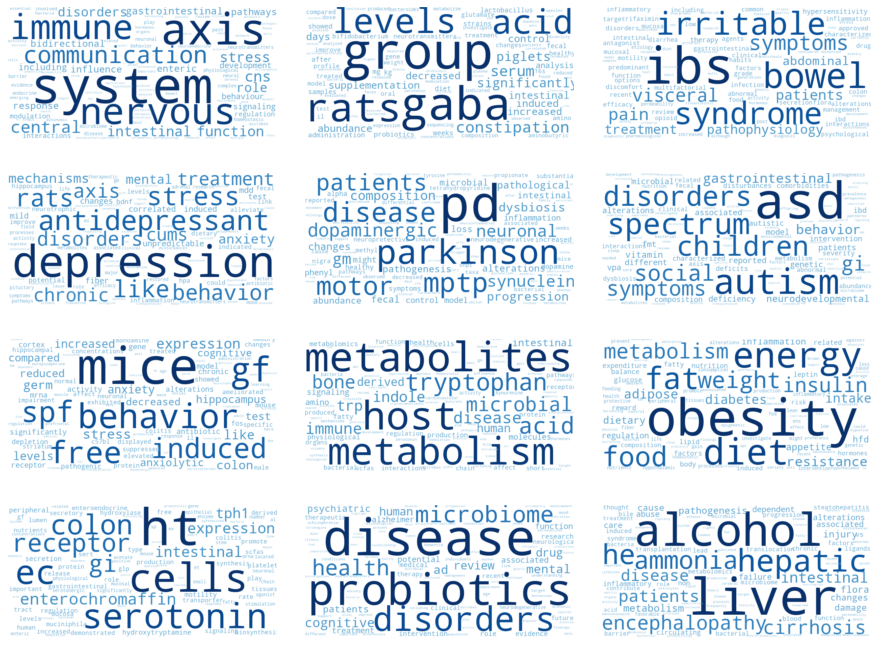

In [23]:
prepare_fig(2, 3)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        #width=395,
        #height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()


## Visualization

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 739 samples in 0.000s...
[t-SNE] Computed neighbors for 739 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 739 / 739
[t-SNE] Mean sigma: 0.156690
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.427856
[t-SNE] KL divergence after 1000 iterations: 0.865409


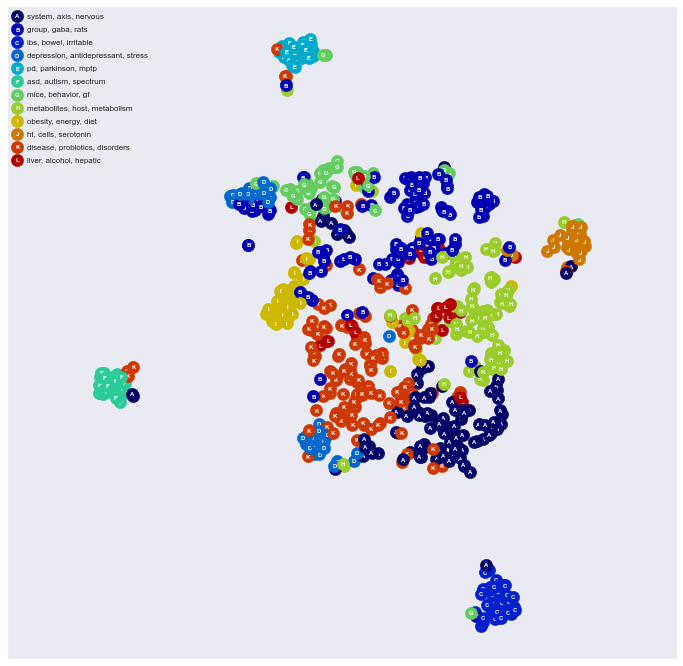

In [24]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=20)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.show()

"wHAT'S BUGGING the GUT in OCD?" A REVIEW of the GUT MICROBIOME in OBSESSIVE-COMPULSIVE DISORDER


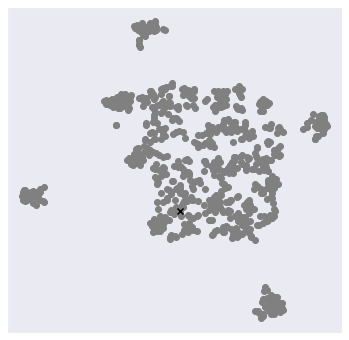

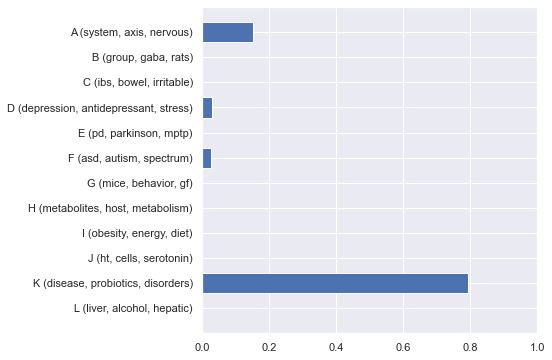

© 2015 Wiley Periodicals, Inc.The gut microbiome has become a topic of major interest as of late, with a new focus specifically on psychiatric disorders. Recent studies have revealed that variations in the composition of the gut microbiota may influence anxiety and mood and vice versa. Keeping the concept of this bidirectional "microbiota-gut-brain" axis in mind, this review aims to shed light on how these findings may also be implicated in obsessive-compulsive disorder (OCD); potentially outlining a novel etiological pathway of interest for future research in the field.


In [25]:
def on_select(i):
    p = papers[i]
    print(p.title)
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(pos.T[0], pos.T[1], c='.5')
    plt.scatter(pos[i,0], pos[i,1], c='0', marker='x')
    plt.show()

    top_words = np.argsort(topic2token, axis=1)[:,::-1]
    ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]
    
    fig = prepare_fig(1, 2)
    plt.barh(range(num_topics), doc2topic[i])
    plt.xlim(0, 1)
    plt.ylim(num_topics, -1)
    plt.yticks(range(num_topics), ticks)
    plt.show()
    
    print(p.abstract)

options = sorted([((p.title or '').strip()[:50], i) for i, p in enumerate(papers)])
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '2000px'
widget